# Introduction

This Jupyter Notebook demonstrates how one might use the NCAR Community Earth System Model (CESM)
Large Ensemble (LENS) data hosted on AWS S3 ([doi:10.26024/wt24-5j82](https://doi.org/10.26024/wt24-5j82)). The notebook shows how to reproduce figures 2 and 4 from the Kay et al. (2015) paper describing the CESM LENS dataset ([doi:10.1175/BAMS-D-13-00255.1](https://doi.org/10.1175/BAMS-D-13-00255.1))

This resource is intended to be helpful for people not familiar with elements of the [Pangeo](https://pangeo.io) framework including Jupyter Notebooks, [Xarray](http://xarray.pydata.org/), and [Zarr](https://zarr.readthedocs.io/) data format, or with the original paper, so it includes additional explanation.

Notebook version 3.2 (2019 Nov 22): https://github.com/NCAR/cesm-lens-aws


## Set up environment

In [1]:
# Display output of plots directly in Notebook
%matplotlib inline

# Silence dask.distributed logs
import logging
import warnings

import dask.config
import intake
import numpy as np
import pandas as pd
import xarray as xr

warnings.filterwarnings("ignore")

logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)
dask.config.set({"distributed.logging.distributed": "error"})


xr.set_options(display_style="html")

## Create and Connect to Dask Distributed Cluster

In [ ]:
# Create cluster
from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster()
cluster.adapt(minimum=2, maximum=25, wait_count=60)
# Connect to cluster
client = Client(cluster)
# Display cluster dashboard URL
cluster


☝️ Link to scheduler dashboard will appear above.

In [2]:
from dask_gateway import GatewayCluster
from dask.distributed import Client

cluster = GatewayCluster()
cluster.adapt(minimum=2, maximum=25)
client = cluster.get_client()
cluster

In [4]:
client?

Type:        Client
String form: <Client: 'tls://192.168.124.176:44911' processes=2 threads=4, memory=8.59 GB>
File:        /srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py
Docstring:  
Connect to and submit computation to a Dask cluster

The Client connects users to a Dask cluster.  It provides an asynchronous
user interface around functions and futures.  This class resembles
executors in ``concurrent.futures`` but also allows ``Future`` objects
within ``submit/map`` calls.  When a Client is instantiated it takes over
all ``dask.compute`` and ``dask.persist`` calls by default.

It is also common to create a Client without specifying the scheduler
address , like ``Client()``.  In this case the Client creates a
:class:`LocalCluster` in the background and connects to that.  Any extra
keywords are passed from Client to LocalCluster in this case.  See the
LocalCluster documentation for more information.

Parameters
----------
address: string, or Cluster
    This c

In [3]:
client

Client Scheduler: gateway://scheduler-public-icesat2-prod-dask-gateway:8786/5c314a725b2948c5a8c400033d3167b6 Dashboard: /user/salvis2/proxy/46869/status,Cluster Workers: 2 Cores: 4 Memory: 8.59 GB


In [25]:
cluster.shutdown()

## Load data into xarray from a catalog using intake-esm

- [Intake-esm Documentation](https://intake-esm.readthedocs.io/en/latest/notebooks/tutorial.html)

In [3]:
# Open collection description file
intakeEsmUrl = (
    "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
)
col = intake.open_esm_datastore(intakeEsmUrl)
print(col._col_data["description"])  # Description of collection
print("Catalog file:", col._col_data["catalog_file"])
print(col)  # Summary of collection structure

This is an ESM collection for CESM1 Large Ensemble Zarr dataset publicly available on Amazon S3 (us-west-2 region)
Catalog file: https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.csv
aws-cesm1-le-ESM Collection with 302 entries:
	> 5 component(s)

	> 5 frequency(s)

	> 6 experiment(s)

	> 54 variable(s)

	> 302 path(s)



In [4]:
# Show expanded version of collection structure with details
import pprint

uniques = col.unique(columns=["component", "frequency", "experiment", "variable"])
pprint.pprint(uniques, compact=True, indent=4)

{   'component': {   'count': 5,
                     'values': ['atm', 'ice_nh', 'ice_sh', 'lnd', 'ocn']},
    'experiment': {   'count': 6,
                      'values': [   '20C', 'RCP85', 'CTRL', 'CTRL_AMIP',
                                    'CTRL_SLAB_OCN', 'HIST']},
    'frequency': {   'count': 5,
                     'values': [   'daily', 'hourly6-1990-2005',
                                   'hourly6-2026-2035', 'hourly6-2071-2080',
                                   'monthly']},
    'variable': {   'count': 54,
                    'values': [   'FLNS', 'FLNSC', 'FLUT', 'FSNS', 'FSNSC',
                                  'FSNTOA', 'ICEFRAC', 'LHFLX', 'PRECL',
                                  'PRECSC', 'PRECSL', 'PRECT', 'PRECTMX', 'PSL',
                                  'Q850', 'SHFLX', 'TMQ', 'TREFHT', 'TREFHTMN',
                                  'TREFHTMX', 'TS', 'UBOT', 'WSPDSRFAV', 'Z500',
                                  'PS', 'Q', 'QREFHT', 'T', 'U', 'V', 'Z3',

In [5]:
# Show the first few lines of the catalog
col.df.head(10)

,component,frequency,experiment,variable,path
0,atm,daily,20C,FLNS,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNS....
1,atm,daily,20C,FLNSC,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNSC...
2,atm,daily,20C,FLUT,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLUT....
3,atm,daily,20C,FSNS,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNS....
4,atm,daily,20C,FSNSC,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNSC...
5,atm,daily,20C,FSNTOA,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FSNTO...
6,atm,daily,20C,ICEFRAC,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-ICEFR...
7,atm,daily,20C,LHFLX,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-LHFLX...
8,atm,daily,20C,PRECL,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-PRECL...
9,atm,daily,20C,PRECSC,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-PRECS...


In [6]:
# Optional: inspect the collection object
# import inspect
# inspect.getmembers(col)

## Extract data needed to construct Figure 2 of Kay et al. paper

In [22]:
# Search the catalog to find the desired data, in this case the reference height temperature
# of the atmosphere, at daily time resolution, for both the 20th Century and RCP8.5 (IPCC
# Representative Concentration Pathway 8.5) experiments
col_subset = col.search(
    frequency="daily", component="atm", variable="TREFHT", experiment=["20C", "RCP85"]
)
print("Data subset:")
col_subset.df

Data subset:


,component,frequency,experiment,variable,path
0,atm,daily,20C,TREFHT,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-TREFH...
1,atm,daily,RCP85,TREFHT,s3://ncar-cesm-lens/atm/daily/cesmLE-RCP85-TRE...


In [8]:
# Load catalog entries for subset into a dictionary of xarray datasets
# Note: This step may take a couple of minutes.
dsets = col_subset.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)
print("\nDataset dictionary keys:\n", dsets.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'
                
--> There is/are 2 group(s)

Dataset dictionary keys:
 dict_keys(['atm.20C.daily', 'atm.RCP85.daily'])


In [9]:
# Define Xarray datasets corresponding to the two experiments
ds_20C = dsets["atm.20C.daily"]
ds_RCP85 = dsets["atm.RCP85.daily"]

In [10]:
# Use Dask.Distributed utility function to display size of each dataset
from distributed.utils import format_bytes

print(
    "20th Century:",
    format_bytes(ds_20C.nbytes),
    "\nRCP8.5:",
    format_bytes(ds_RCP85.nbytes),
)

20th Century: 277.72 GB 
RCP8.5: 306.79 GB


In [11]:
# Extract the Reference Height Temperature data variable
t_20c = ds_20C["TREFHT"]
t_rcp = ds_RCP85["TREFHT"]
print("Description of 20C data:")
display(t_20c)

Description of 20C data:


,Array,Chunk
Bytes,277.72 GB,161.46 MB
Shape,"(40, 31390, 192, 288)","(2, 365, 192, 288)"
Count,1721 Tasks,1720 Chunks
Type,float32,numpy.ndarray


In [12]:
# The global surface temperature anomaly was computed relative to the 1961-90 base period
# in the Kay et al. paper, so extract that time slice
t_ref = t_20c.sel(time=slice("1961", "1990"))

## Read grid cell areas
Cell size varies with latitude, so this must be accounted for when computing the global mean.

Note: Each Zarr store includes area values and other ancillary information in addition to the
actual data. A possible optimization to reduce data size would be to extract the duplicated
information into separate objects.

In [13]:
cell_area = ds_20C.area
total_area = cell_area.sum()
cell_area

<xarray.DataArray 'area' (lat: 192, lon: 288)>
dask.array<zarr, shape=(192, 288), dtype=float32, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    long_name:      Grid-Cell Area
    standard_name:  cell_area
    units:          m2

## Define Weighted Means
Note: resample(time="AS") does an Annual resampling based on Start of calendar year.
See documentation for [Pandas resampling options](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)

In [14]:
t_ref_ts = (
    (t_ref.resample(time="AS").mean("time") * cell_area).sum(dim=("lat", "lon"))
    / total_area
).mean(dim=("time", "member_id"))

t_20c_ts = (
    (t_20c.resample(time="AS").mean("time") * cell_area).sum(dim=("lat", "lon"))
) / total_area

t_rcp_ts = (
    (t_rcp.resample(time="AS").mean("time") * cell_area).sum(dim=("lat", "lon"))
) / total_area

## Read data and compute means
Note: Pangeo's "lazy execution" philosophy means that until this point we have not actually read the bulk of the data. These steps take a while to complete, so we include the Notebook "cell magic" directive %%time to display elapsed and CPU times after computation.

In [23]:
%%time
t_ref_mean = t_ref_ts.load()
t_ref_mean

CPU times: user 103 µs, sys: 5 µs, total: 108 µs
Wall time: 110 µs


<xarray.DataArray ()>
array(286.38766, dtype=float32)

In [24]:
%%time
t_20c_ts_df = t_20c_ts.to_series().unstack().T
t_20c_ts_df.head()

CPU times: user 7.26 s, sys: 256 ms, total: 7.51 s
Wall time: 2min 8s


member_id,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,101,102,103,104,105
time,,,,,,,,,,,,,,,,,,,,,
1920-01-01 00:00:00,286.311310,286.346710,286.283875,286.363983,286.328400,286.373444,286.386017,286.302185,286.374878,286.348358,...,286.243469,286.283783,286.173859,286.309509,286.296234,286.341064,286.341187,286.376831,286.321167,286.254822
1921-01-01 00:00:00,286.250641,286.198181,286.287292,286.390564,286.309204,286.334229,286.311310,286.300232,286.315857,286.305603,...,286.179413,286.315674,286.075104,286.295990,286.318085,286.375275,286.246063,286.356201,286.492523,286.224274
1922-01-01 00:00:00,286.293488,286.296356,286.265686,286.336517,286.293579,286.220093,286.010773,286.195099,286.205170,286.396545,...,286.142365,286.316254,286.140167,286.293549,286.327972,286.142365,286.412598,286.369232,286.503418,286.282074
1923-01-01 00:00:00,286.329163,286.322662,286.251099,286.322723,286.237457,286.152069,286.066040,286.204498,286.271454,286.292236,...,286.168762,286.300781,286.095490,286.116302,286.227905,286.226440,286.512909,286.381348,286.215302,286.396332
1924-01-01 00:00:00,286.307465,286.237366,286.148895,286.311890,286.361694,286.185974,286.248352,286.288177,286.330444,286.411835,...,286.143066,286.287079,286.234100,286.199890,286.252777,286.322815,286.256165,286.221588,286.247437,286.422028


In [17]:
%%time
t_rcp_ts_df = t_rcp_ts.to_series().unstack().T
t_rcp_ts_df.head()

CPU times: user 7.91 s, sys: 286 ms, total: 8.19 s
Wall time: 1min 54s


member_id,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,101,102,103,104,105
time,,,,,,,,,,,,,,,,,,,,,
2006-01-01 00:00:00,286.764832,286.960358,286.679230,286.793152,286.754547,287.022339,286.850464,287.089844,286.960022,286.775787,...,286.866089,286.925049,286.663971,286.955414,286.712524,287.115601,286.863556,286.881683,287.308411,287.030334
2007-01-01 00:00:00,287.073792,286.908539,286.808746,286.998901,286.841675,286.993042,286.914124,286.938965,286.933563,286.675385,...,286.804108,286.849548,286.628204,287.010529,286.811523,287.187225,286.862823,287.008240,287.222534,287.239044
2008-01-01 00:00:00,287.104095,286.815033,286.995056,287.081543,287.100708,286.960510,286.854706,286.878937,287.062927,286.702454,...,286.825653,286.844086,286.811859,286.803741,286.956635,287.080994,286.930084,286.945801,287.087128,287.157745
2009-01-01 00:00:00,286.984497,287.059418,287.010498,287.144745,286.948700,287.092316,286.888458,287.050964,287.138428,286.890839,...,286.785797,286.876556,286.953094,287.060364,287.056885,287.124908,287.005615,287.083984,287.254211,287.060730
2010-01-01 00:00:00,286.991821,287.102295,286.988159,286.875183,286.954407,287.121796,286.938843,287.116211,286.957245,287.049622,...,286.937317,286.928284,286.980499,287.118713,287.178040,287.030212,287.114716,287.083038,287.256927,287.066528


## Get Observations for Figure 2 (HadCRUT4; Morice et al. 2012)

In [6]:
cat = intake.Catalog("catalog.yml")

In [7]:
cat

<Intake catalog: None>

In [8]:
# Observational time series data for comparison with ensemble average
ds = cat.HadCRUT4.to_dask()
ds

AttributeError: HadCRUT4

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/tornado/iostream.py", line 1417, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.7/ssl.py", line 1139, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLError: [SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1076)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/tornado/iostream.py", line 711, in _handle_events
    self._handle_read()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/tornado/io

- **Obs mean: weight by days in each month**

In [ ]:
def weighted_temporal_mean(ds):
    time_bound_diff = ds.time_bnds.diff(dim="nbnds")[:, 0]
    wgts = time_bound_diff.groupby("time.year") / time_bound_diff.groupby(
        "time.year"
    ).sum(xr.ALL_DIMS)
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)
    obs = ds["air"]
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")
    obs_s = (obs_sum / ones_out).mean(("lat", "lon")).to_series()
    return obs_s

In [ ]:
obs_s = weighted_temporal_mean(ds)
obs_s.head()

In [ ]:
all_ts_anom = pd.concat([t_20c_ts_df, t_rcp_ts_df]) - t_ref_mean.data
years = [val.year for val in all_ts_anom.index]

## Figure 2: Global surface temperature anomaly (1961-90 base period) for individual ensemble members, and observations

In [20]:
import matplotlib.pyplot as plt

NameError: name 'years' is not defined

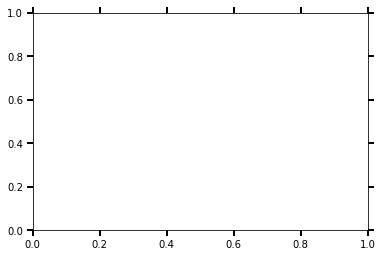

In [21]:
ax = plt.axes()

ax.tick_params(right=True, top=True, direction="out", length=6, width=2, grid_alpha=0.5)
ax.plot(years, all_ts_anom, color="grey")
ax.plot(years, all_ts_anom[1], color="black")
ax.plot(obs_s.index.year.tolist(), obs_s, color="red")

ax.text(
    0.3,
    0.4,
    "observations",
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="red",
    fontsize=10,
)
ax.text(
    0.3,
    0.3,
    "members 1-40",
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="grey",
    fontsize=10,
)

ax.set_xticks([1850, 1920, 1950, 2000, 2050, 2100])
plt.ylim(-1, 5)
plt.xlim(1850, 2100)
plt.ylabel("Global Surface\nTemperature Anomaly (K)")
plt.show()

Figure will appear above when ready. Compare with Fig.2 of Kay et al. 2015 ([doi:10.1175/BAMS-D-13-00255.1](https://doi.org/10.1175/BAMS-D-13-00255.1))

## Compute Linear Trend for Winter Seasons

In [ ]:
def linear_trend(da, dim="time"):
    da_chunk = da.chunk({dim: -1})
    trend = xr.apply_ufunc(
        calc_slope,
        da_chunk,
        vectorize=True,
        input_core_dims=[[dim]],
        output_core_dims=[[]],
        output_dtypes=[np.float],
        dask="parallelized",
    )
    return trend


def calc_slope(y):
    """ufunc to be used by linear_trend"""
    x = np.arange(len(y))

    # drop missing values (NaNs) from x and y
    finite_indexes = ~np.isnan(y)
    slope = (
        np.nan
        if (np.sum(finite_indexes) < 2)
        else np.polyfit(x[finite_indexes], y[finite_indexes], 1)[0]
    )
    return slope

### Compute ensemble trends

In [ ]:
t = xr.concat([t_20c, t_rcp], dim="time")
seasons = t.sel(time=slice("1979", "2012")).resample(time="QS-DEC").mean("time")
# Include only full seasons from 1979 and 2012
seasons = seasons.sel(time=slice("1979", "2012")).load()

In [ ]:
winter_seasons = seasons.sel(
    time=seasons.time.where(seasons.time.dt.month == 12, drop=True)
)
winter_trends = linear_trend(
    winter_seasons.chunk({"lat": 20, "lon": 20, "time": -1})
).load() * len(winter_seasons.time)

# Compute ensemble mean from the first 30 members
winter_trends_mean = winter_trends.isel(member_id=range(30)).mean(dim="member_id")
winter_trends_mean

In [ ]:
# Make sure that we have 34 seasons
assert len(winter_seasons.time) == 34

### Get Observations for Figure 4 (NASA GISS GisTemp)

Observational time series data for comparison with ensemble average

NASA GISS Surface Temperature Analysis, https://data.giss.nasa.gov/gistemp/

In [ ]:
with dask.config.set(scheduler='single-threaded'):
    ds = cat.gistemp.read().squeeze('concat_dim').chunk({"lat": 20, "lon": 20, "time": -1})

In [ ]:
# # Remap longitude range from [-180, 180] to [0, 360] for plotting purposes
ds = ds.assign_coords(lon=((ds.lon + 360) % 360)).sortby('lon')
ds

### Compute observed trends

In [ ]:
obs_seasons = ds.sel(time=slice("1979", "2012")).resample(time="QS-DEC").mean("time")
# Include only full seasons from 1979 through 2012
obs_seasons = obs_seasons.sel(time=slice("1979", "2012")).load()

# Compute observed winter trends
obs_winter_seasons = obs_seasons.sel(
    time=obs_seasons.time.where(obs_seasons.time.dt.month == 12, drop=True)
)
obs_winter_seasons

In [ ]:
(ds["tempanomaly"].isel(time=50) / 100).plot()

In [ ]:
obs_winter_trends = linear_trend(
    obs_winter_seasons.chunk({"lat": 20, "lon": 20, "time": -1})
).load() * len(obs_winter_seasons.time)
obs_winter_trends

## Figure 4: Global maps of historical (1979 - 2012) boreal winter (DJF) surface air trends

In [ ]:
import cartopy.crs as ccrs
import cmaps  # for NCL colormaps
import matplotlib.pyplot as plt

contour_levels = [-6, -5, -4, -3, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3, 4, 5, 6]

color_map = cmaps.ncl_default

In [ ]:
def make_map_plot(nplot_rows, nplot_cols, plot_index, data, plot_label):
    """ Create a single map subplot. """
    ax = plt.subplot(
        nplot_rows,
        nplot_cols,
        plot_index,
        projection=ccrs.Robinson(central_longitude=180),
    )
    cplot = plt.contourf(
        lons,
        lats,
        data,
        levels=contour_levels,
        cmap=color_map,
        extend="both",
        transform=ccrs.PlateCarree(),
    )
    ax.coastlines(color="grey")
    ax.text(0.01, 0.01, plot_label, fontSize=14, transform=ax.transAxes)
    return cplot, ax

In [ ]:
# Generate plot (may take a while as many individual maps are generated)
numPlotRows = 8
numPlotCols = 4
figWidth = 20
figHeight = 30

fig, axs = plt.subplots(numPlotRows, numPlotCols, figsize=(figWidth, figHeight))

lats = winter_trends.lat
lons = winter_trends.lon

# Create ensemble member plots
for ensemble_index in range(30):
    plot_data = winter_trends.isel(member_id=ensemble_index)
    plot_index = ensemble_index + 1
    plot_label = str(plot_index)
    plotRow = ensemble_index // numPlotCols
    plotCol = ensemble_index % numPlotCols
    # Retain axes objects for figure colorbar
    cplot, axs[plotRow, plotCol] = make_map_plot(
        numPlotRows, numPlotCols, plot_index, plot_data, plot_label
    )

# Create plots for the ensemble mean, observations, and a figure color bar.
cplot, axs[7, 2] = make_map_plot(numPlotRows, numPlotCols, 31, winter_trends_mean, "EM")

lats = obs_winter_trends.lat
lons = obs_winter_trends.lon
cplot, axs[7, 3] = make_map_plot(
    numPlotRows, numPlotCols, 32, obs_winter_trends.tempanomaly, "OBS"
)

cbar = fig.colorbar(cplot, ax=axs, orientation="horizontal", shrink=0.7, pad=0.02)
cbar.ax.set_title(
    "1979-2012 DJF surface air temperature trends (K/34 years)", fontSize=16
)
cbar.set_ticks(contour_levels)
cbar.set_ticklabels(contour_levels)

Figure will appear above when ready. Compare with Fig. 4 of Kay et al. 2015 ([doi:10.1175/BAMS-D-13-00255.1](https://doi.org/10.1175/BAMS-D-13-00255.1)).


In [ ]:
# Gracefully destroy/close our cluster
client.close()
cluster.close()